In [141]:
from astropy.io import fits
import astropy.wcs as wcs
from astropy.nddata import CCDData
from astropy.table import Table
import astropy.units as u
from astropy.nddata import NDDataArray, StdDevUncertainty, NDUncertainty, VarianceUncertainty, InverseVariance
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import aplpy
import itertools
import collections
from copy import deepcopy
from astropy.utils.decorators import sharedmethod
import matplotlib.colors as colors
import scipy.stats as stats
from matplotlib import ticker
from astropy.visualization import AsymmetricPercentileInterval, simple_norm
from skimage import data, exposure
%matplotlib inline

# Mathematical Steps
For a given spatial pixel $p = (x,y)$ with $N$ values of observed line ratios $R_N(p)$ with errors on the line ratios $E_N(p)$ in same units as $R_N$, we use predicted line ratios as function of $A_N(G_0,n)$, to compute differences $\delta_N$ across all $A$:
$${\delta_N^2(p,G_0,n)} = {\left[ R_N(p) - A_N(G_0,n)\over E_N(x)\right] }^2$$
 
The reduced chi-squared for spatial pixel $i$ is then given by

$$\chi^2(p,G_0,n) =  \sum_N {\delta_N^2(p,G_0,n) \over N-1}$$

and the best-fit value of $(G_0,n)$ is the minimum of $\chi^2$  The range of $(G_0,n)$ over which $A_N$ have been computed must be large enough to encompass physically reasonable values in the ISM, typically $10^{-1} < G_0 < 10^7$ in Habing units and $1 < n < 10^7$ cm$^{-3}$

For a spatial map, we do the above computation over all $p$ to produce a spatial maps of $\chi^2$ and best-fit spatial maps of $(G_0,n)$.

# Logical Steps
Given a list of measurement IDs,
1. Find all available matching model ratios
2. For each matching model ratio, compute the corresponding measurement ratios (including error propagation)
3. For each measurement ratio, compute the $\delta^2$ as above, using the ratio label as in index to find the corresponding FITS file of $A(G_0,n)$.
4. Compute $\chi^2$ from the $\delta$'s as above.
    

In [147]:
# maybe this is just better storing this info in a Table.  Then adding models is 
# just adding to the table
class ModelRatioData:
    def __init__(self,numerator, denominator, identifier,filename,metallicity=1):
        self._numerator = numerator
        self._denominator =denominator
        self._identifier = identifier
        self._filename = filename + "web"
        self._metallicity= metallicity
        
    @property
    def id(self): return self._identifier

    @property 
    def filename(self): return self._filename
    
    @property 
    def metallicity(self): return self._metallicity
    
    @property
    def isSolarMetallicity(self):
        return self._metallicity == 1
    
def _arithmetic(op):
    """Decorator factory which temporarly disables the need for a unit when
    creating a new CCDData instance. The final result must have a unit.

    Parameters
    ----------
    op : function
        The function to apply. Supported are:

        - ``np.add``
        - ``np.subtract``
        - ``np.multiply``
        - ``np.true_divide``

    Notes
    -----
    Should only be used on CCDData ``add``, ``subtract``, ``divide`` or
    ``multiply`` because only these methods from NDArithmeticMixin are
    overwritten.
    """
    def decorator(func):
        def inner(self, operand, operand2=None, **kwargs):
            print("doing arithmetic")
            result = self._prepare_then_do_arithmetic(op, operand,
                                                      operand2, **kwargs)
            return result.__class__(result)
        inner.__doc__ = ("See `astropy.nddata.NDArithmeticMixin.{}`."
                         "".format(func.__name__))
        return sharedmethod(inner)
    return decorator

def _uncertainty_unit_equivalent_to_parent(uncertainty_type, unit, parent_unit):
    if uncertainty_type is StdDevUncertainty:
        return unit == parent_unit
    elif uncertainty_type is VarianceUncertainty:
        return unit == (parent_unit ** 2)
    elif uncertainty_type is InverseVariance:
        return unit == (1 / (parent_unit ** 2))
    raise ValueError("unsupported uncertainty type: {}"
                     .format(uncertainty_type))

class Measurement(NDDataArray):
    def __init__(self,*args, **kwargs):
        self._identifier = kwargs.pop('identifier', None)
        super().__init__(*args, **kwargs)
    
    @property
    def id(self): return self._identifier
    
    add = _arithmetic(np.add)(NDDataArray.add)
    subtract = _arithmetic(np.subtract)(NDDataArray.subtract)
    multiply = _arithmetic(np.multiply)(NDDataArray.multiply)
    divide = _arithmetic(np.true_divide)(NDDataArray.divide)
        
    
class Measurement0(NDDataArray):
    def __init__(self,*args, **kwargs):
        self._identifier = kwargs.pop('identifier', None)
        super().__init__(*args, **kwargs)
        print(self._uncertainty.parent_nddata)
        #.parent_nddata(self._data)
        
    @property
    def flux(self):
        return self.data
    
    @property
    def id(self):
        return self._identifier
    
    @property
    def error(self):
        return self.uncertainty
    
    
    def add(self,other):
        z=super().add(other)
        z._identifier = self.id + '+' + other.id
        return z
   
    def subtract(self,other):
        z=super().subtract(other)
        z._identifier = self.id + '-' + other.id
        return z
    
    def multiply(self,other):
        #zz = super()
        #print(type(zz))
        z=super().multiply(other)
        #print(self.id,other.id)
        z._identifier = self.id + '*' + other.id
        return z
        
    def divide(self,other):
        #zz = super()
        #print(type(zz))
        z=super().divide(other)
        #print(self.id,other.id)
        z._identifier = self.id + '/' + other.id
        return z
    
    def __add__(self,other):
        z=self.add(other)
        return z
    def __sub__(self,other):      
        z=self.subtract(other)
        return z
    
    def __mul__(self,other):
        z=self.multiply(other)
        return z
    
    def __truediv__(self,other):
        z=self.divide(other)
        return z
    
class PDRutils:
    def __init__(self,models):
        if type(models) == str:
            self.initializeFromFile(models)
        else:
            self._models = models
        self._fitsfiles = None
        
    def makeDefaultTable(self):
        ratiodict = {
        "OI_145/OI_63"   : "oioi",
        "OI_145/CII_158" : "o145cii",
        "OI_63/CII_158"  : "oicp",
        "CII_158/CI_609" : "ciici609",
        "CI_370/CI_609"  : "cici",
        "CII_158/CO_10"  : "ciico",
        "CI_609/CO_10"   : "cico",
        "CI_609/CO_21"   : "cico21",
        "CI_609/CO_32"   : "cico32",
        "CI_609/CO_43"   : "cico43",
        "CI_609/CO_54"   : "cico54",
        "CI_609/CO_65"   : "cico65",
        "CO_21/CO_10"    : "co2110",
        "CO_32/CO_10"    : "co3210",
        "CO_32/CO_21"    : "co3221",
        "CO_43/CO_21"    : "co4321",
        "CO_65/CO_10"    : "co6510",
        "CO_65/CO_21"    : "co6521",
        "CO_65/CO_54"    : "co6554",
        "CO_76/CO_10"    : "co7610",
        "CO_76/CO_21"    : "co7621",
        "CO_76/CO_43"    : "co7643",
        "CO_76/CO_54"    : "co7654",
        "CO_76/CO_65"    : "co7665",
        "CO_87/CO_54"   : "co8754",
        "CO_87/CO_65"   : "co8765",
        "CO_98/CO_54"   : "co9854",
        "CO_98/CO_65"   : "co9865",
        "CO_109/CO_54"   : "co10954",
        "CO_109/CO_65"   : "co10965",
        "CO_1110/CO_54"   : "co111054",
        "CO_1110/CO_65"   : "co111065",
        "CO_1211/CO_54"   : "co121154",
        "CO_1211/CO_65"   : "co121165",
        "CO_1312/CO_54"   : "co131254",
        "CO_1312/CO_65"   : "co131265",
        "CO_1413/CO_54"   : "co141354",
        "CO_1413/CO_65"   : "co141365",
        "OI_63+CII_158/FIR"     : "fir",
        "OI_145+CII_158/FIR"  : "firoi145",
        "SIII_Z1/FEII_Z1"  : "siii35feii26z1",
        "SIII_Z3/FEII_Z3"  : "siii35feii26z3",
        "H200S1_Z1/H200S0_Z1" : "h200s1s0z1",
        "H200S1_Z3/H200S0_Z3" : "h200s1s0z3",
        "H200S2_Z1/H200S0_Z1" : "h200s2s0z1",
        "H200S2_Z3/H200S0_Z3" : "h200s2s0z3",
        "H200S2_Z1/H200S1_Z1" : "h200s2s1z1",
        "H200S2_Z3/H200S1_Z3" : "h200s2s1z3",
        "H200S3_Z1/H200S1_Z1" : "h200s3s1z1",
        "H200S3_Z3/H200S1_Z3" : "h200s3s1z3",
        "H200S1_Z1/SIII_Z1" : "h200s1siiiz1",
        "H200S1_Z3/SIII_Z3" : "h200s1siiiz3",
        "H200S2_Z1/SIII_Z1" : "h200s2siiiz1",
        "H200S2_Z3/SIII_Z3" : "h200s2siiiz3",
        "H264Q1_Z1/H210S1_Z1" : "h264q110s1z1",
        "H264Q1_Z3/H210S1_Z3" : "h264q110s1z3"
        }
        a = list()
        b = list()
        for r in ratiodict:
            nd = r.split("/")
            if ("Z3" in r):
                z=3
            else:
                z=1
            b.append((nd[0],nd[1],r,ratiodict[r]+"web",z))
            a.append(ModelRatioData(nd[0],nd[1],r,ratiodict[r],z))
        t = Table(rows=b,names=("numerator","denominator","label","filename","z"))
        t.add_index("label")
        t.write("current_models.tab",format="ascii.ipac",overwrite=True)
  
    def initializeFromFile(self,filename):
        """initialize models from an IPAC format ASCII file"""
        self._models=Table.read(filename,format="ascii.ipac")
        self._models.add_index("label")
    
   
    def find_ratio_elements(self,m):
        """Return an iterator of valid numerator,denominator pairs in 
        dict format for the given list of measurement IDs
        """
        if not isinstance(m, collections.abc.Iterable) or isinstance(m, (str, bytes)) :
            raise Exception("m must be an array of strings")
            
        for q in itertools.product(m,m):
            s = q[0]+"/"+q[1]
            z = dict()
            if s in self._models["label"]:
                z={"numerator":self._models.loc[s]["numerator"],
                   "denominator":self._models.loc[s]["denominator"]}
                yield(z)
                
    def get_ratio_elements(self,m):   
        """Return a list of valid numerator,denominator pairs in dict format for the 
        given list of measurement IDs
        """
        if not isinstance(m, collections.abc.Iterable) or isinstance(m, (str, bytes)) :
            raise Exception("m must be an array of strings")
        k = list()   
        for q in itertools.product(m,m):
            s = q[0]+"/"+q[1]
            if s in self._models["label"]:
                z={"numerator":self._models.loc[s]["numerator"],
                   "denominator":self._models.loc[s]["denominator"]}
                k.append(z)
                
        return k
        
            
    def find_pairs(self,m):
        """Return an iterator of model ratios labels for the given list of measurement IDs"""
        if not isinstance(m, collections.abc.Iterable) or isinstance(m, (str, bytes)) :
            raise Exception("m must be an array of strings")
            
        for q in itertools.product(m,m):
            s = q[0]+"/"+q[1]
            if s in self._models["label"]:
                yield(s)
    
    def find_files(self,m,ext="fits"):
        """Return an iterator of model ratio files for the given list of measurement IDs"""
        if not isinstance(m, collections.abc.Iterable) or isinstance(m, (str, bytes)):
            raise Exception("m must be an array of strings")
        for q in itertools.product(m,m):
            s = q[0]+"/"+q[1]
            if s in self._models["label"]:
                tup = (s,self._models.loc[s]["filename"]+"."+ext)
                #yield(self._models.loc[s]["filename"]+"."+ext)
                yield(tup)
    
    def ratiocount(self,m):
        """Return the number of model ratios found for the given list of measurement IDs"""
        # since find_files is a generator, we can't use len(), so do this sum.
        # See https://stackoverflow.com/questions/393053/length-of-generator-output
        return(sum(1 for _ in self.find_files(m)))
                
    def read_fits(self,m):
        """Given a list of measurement IDs, find and open the FITS files that have matching ratios
           and populate the _fitsfiles dictionary
        """
        d = "/n/lupus/mpound/WITS/Docs/pdrt/"
        self._fitsfiles = dict()
        for (k,p) in self.find_files(m):
            self._fitsfiles[k] = fits.open(d+p)
            
    def read_ccd(self,m,unit):
        """Test method to use astropy's CCDdata as a storage mechanism for our model 
           ratio or observer data FITS files.
            Parameters: 
                 m - list of measurement IDS (string)
                 unit - units of the data (string)
        """
        d = "/n/lupus/mpound/WITS/Docs/pdrt/"
        self._fitsfiles = dict()
        for (k,p) in self.find_files(m):
            self._fitsfiles[k] = CCDData.read(d+p,unit=unit)
    
    def doit(self,measurements):
        #measurements is a dict
        mids = measurements.keys()
        #self.read_fits(mids)
        self.read_ccd(mids,unit='adu')
        self.computeValidRatios(measurements)
        self.computeDeltaSq(mids)
        self.computeChisq()
        #self.plotChisq()
      
    def computeValidRatios(self,measurements):
        z = self.find_ratio_elements(measurements.keys())
        self._ratios = dict()
        for p in z:
            label = p["numerator"]+"/"+p["denominator"]
            # deepcopy workaround for bug: https://github.com/astropy/astropy/issues/9006
            self._ratios[label] = deepcopy(measurements[p["numerator"]])/deepcopy(measurements[p["denominator"]])
        
    
    def computeDeltaSq(self,measurements):
        #@todo perhaps don't store _fitsfiles but have them be a return value of read_fits.
        # reasoning is that if we use the same PDRUtils object to make multiple computations, we
        # have to be careful to clear _fitsfiles each time.
        
        if not self._fitsfiles: # empty list or None
            raise Exception("No model data ready.  You need to call read_fits")
        
        self._deltasq = dict()
        for r in self._ratios:
            #print(self._ratios[r])
            #print(self._fitsfiles[r])
            _z = self._fitsfiles[r].multiply(-1.0)
            _z._data = _z._data + self._ratios[r].flux
            _q = _z.divide(self._ratios[r].error._array)
            self._deltasq[r] = _q.multiply(_q)
            #delta[r] = ((self._ratios[r].flux - self._fitsfiles[r].data)/self._ratios[r].error)**2
        
    def computeChisq(self):
        sumary = sum((self._deltasq[r]._data for r in self._deltasq))
        self._dof = len(self._deltasq) - 1
        k = list(self._deltasq.keys())[0]
        self._chisq = CCDData(sumary,unit='adu',wcs=self._deltasq[k].wcs)
        self._reducedChisq =  self._chisq.divide(self._dof)
        
    def plotReducedChisq(self,cmap='plasma',contours=True,levels=None):
        pass
    
    def plotConfidenceIntervals(self,image=True, cmap='plasma',contours=True,levels=None):
        chi2_stat = stats.distributions.chi2.cdf(self._chisq.data,self._dof)
        if image: plt.imshow(chi2_stat*100,aspect='auto',cmap=cmap)
        print(100*chi2_stat.min(),100*chi2_stat.max())
        if contours:
            if levels==None:
                levels = [68.,80., 95., 99.]
            plt.contour(chi2_stat*100,colors='black',levels=sorted(levels))
            
    def plotChisq(self,cmap='plasma',contours=True,levels=None):
        self._reducedChisq.write("chisq.fits",overwrite=True)
        k = fits.open("chisq.fits")[0]
        min_ = self._chisq.data.min()
        max_ = self._chisq.data.max()
        ax=plt.subplot(111)
        ax.set_aspect('equal')
        normalizer = simple_norm(self._chisq.data, min_cut=min_,max_cut=max_, stretch='log', clip=False)
        #ax.imshow(self._chisq.data,cmap=cmap,
        #          aspect="equal",norm=normalizer)
                  #norm=colors.LogNorm(vmin=min_, vmax=max_))
        xstart=k.header['crval1']
        xstop=xstart+k.header['naxis1']*k.header['cdelt1']
        ystart=k.header['crval2']
        ystop=ystart+k.header['naxis2']*k.header['cdelt2']
        #print(xstart,xstop,ystart,ystop)
    
        y = 10**np.linspace(start=ystart, stop=ystop, num=k.header['naxis2'])
        x = 10**np.linspace(start=xstart, stop=xstop, num=k.header['naxis1'])
        ax.set_xscale('log')
        ax.set_yscale('log')
        if False:
            chihist = exposure.equalize_hist(self._chisq.data)
            ax.pcolormesh(x,y,chihist,cmap=cmap)
        ax.pcolormesh(x,y,self._chisq.data,cmap=cmap,norm=normalizer)
        
        locmaj = ticker.LogLocator(base=10.0, subs=(1.0, ),numticks=10)
        ax.xaxis.set_major_locator(locmaj)
        locmin = ticker.LogLocator(base=10.0, subs=np.arange(2, 10)*.1,numticks=10) 
        ax.xaxis.set_minor_locator(locmin)
        ax.xaxis.set_minor_formatter(ticker.NullFormatter())
        ylab = 'Log($G_0$) [Habing]'
        ss = 'Log($P_{th}/k$) [cm$^{-2}$]'
        xlab = 'Log(n) [cm$^{-3}$]'
        ax.set_ylabel(ylab)
        ax.set_xlabel(xlab)

        if contours:
            if levels == None:
                levels_ = np.array([2.,6.,12.,18.])*min_
            ax.contour(x,y,self._chisq.data, levels=levels_, colors='white')
           
    
    def plotChisq2(self,cmap='plasma',contours=True,levels=None):
        self._chisq.write("chisq.fits",overwrite=True)
        min_ = self._chisq.data.min()
        max_ = self._chisq.data.max()
        gc = aplpy.FITSFigure("chisq.fits")
        gc.show_colorscale(cmap=cmap,vmin=min_, vmax=max_,stretch='log')
        gc.axis_labels.set_ytext('Log($G_0$) [Habing]')
        gc.axis_labels.set_xtext('Log(n) [cm$^{-3}$] ')
        if contours:
            if levels == None:
                levels_ = np.array([2.,6.,12.,18.])*min_
                gc.show_contour(colors='white',levels=levels_)
            else:
                gc.show_contour(colors='white',levels=levels)
    
    
                

In [148]:
m1 = Measurement0(data=30.,uncertainty = StdDevUncertainty(5.),identifier="OI_145")
m2 = Measurement0(data=10.,uncertainty = StdDevUncertainty(2.),identifier="CI_609")
m3 = Measurement0(data=10.,uncertainty = StdDevUncertainty(1.5),identifier="CO_21")
m4 = Measurement0(data=100.,uncertainty = StdDevUncertainty(10.),identifier="CII_158")
m = [m1.id,m2.id,m3.id,m4.id]
md = dict()
for t in [m1,m2,m3,m4]:
    md[t.id] = t
print(md)
m1.__dict__

30.0
10.0
10.0
100.0
{'OI_145': Measurement0(30.), 'CI_609': Measurement0(10.), 'CO_21': Measurement0(10.), 'CII_158': Measurement0(100.)}


{'_identifier': 'OI_145',
 '_data': array(30.),
 '_mask': False,
 '_wcs': None,
 '_meta': OrderedDict(),
 '_unit': None,
 '_uncertainty': StdDevUncertainty(5.0),
 '_flags': None}

<b>Ok, so this error went poof.  After spending much of a day chasing this down, it has disappeared...</b>
*I don't really understand iterators.  Using find_ratio_elements in a loop causes an error if one tried to divide a Measurement indexed by numerator by a Measurement indexed by denominator. Example below. The error has to do with "no parent data" for the uncertainty.  It only happens with an iterator and not a list (get_ratio_elements).* 

In [149]:
p = PDRutils("current_models.tab")
m = pd.Series([m1.id,m2.id,m3.id,m4.id])
p.ratiocount(m)
#x = p.get_ratio_elements(m)
#print(x)
if False:
    for _z in p.find_ratio_elements(m):
        # we are forced to make a deep copy here otherwise an attribute error is raised.
        # See https://github.com/astropy/astropy/issues/9006
       _m1 = deepcopy(md[_z["numerator"]])
       _m2 = deepcopy(md[_z["denominator"]])
       #m3 = md[x[xx]["numerator"]]/md[x[xx]["denominator"]]
       _m3=_m1/(_m2)
       print("u=",_m3.uncertainty)


In [150]:
p.doit(md)

100.0
0.3
10.0
1.0
10.0
10.0


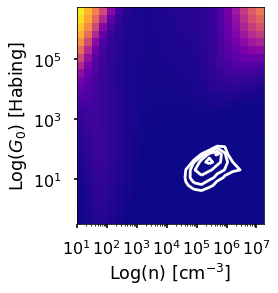

In [151]:
#plt.style.use('seaborn-poster')
p.plotChisq(cmap='plasma')
#p.plotConfidenceIntervals(cmap='gray',levels=[68,75,95,99], image=False)

In [ ]:
x = CCDData.read("/lupus/mpound/WITS/Docs/pdrt/co7610webpth.fits",unit='adu')
z = fits.open("/lupus/mpound/WITS/Docs/pdrt/co7610webpth.fits")

In [ ]:
 print(plt.style.available)

In [ ]:
plt.style.use('seaborn-poster')
k=z[0]
#k.verify('fix')
print(wcs.find_all_wcs(k.header))
#wcs.validate("/lupus/mpound/WITS/Docs/pdrt/co7610webpth.fits")
k.header

In [ ]:


mywcs = wcs.WCS(k.header)
fig, (ax,ax2) = plt.subplots(ncols=2)#,projection=mywcs)
#ax=plt.subplot(121,projection=mywcs)
#ax2=plt.subplot(122)
ax.imshow(k.data,cmap='plasma',aspect="auto",extent=(100,10**7.25,10*-0.5,10**8.25))
ax.set_xscale('log')
ax.set_yscale('log')
xstart=k.header['crval1']
xstop=xstart+k.header['naxis1']*k.header['cdelt1']
ystart=k.header['crval2']
ystop=ystart+k.header['naxis2']*k.header['cdelt2']
print(xstart,xstop,ystart,ystop)
#stop=k.header[]
y = 10**np.linspace(start=ystart, stop=ystop, num=k.header['naxis2'])
x = 10**np.linspace(start=xstart, stop=xstop, num=k.header['naxis1'])
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.pcolormesh(x,y,k.data,cmap='plasma')
#ax2.autoscale('tight')
locmaj = ticker.LogLocator(base=10.0, subs=(1.0, ),numticks=10)
ax2.xaxis.set_major_locator(locmaj)
locmin = ticker.LogLocator(base=10.0, subs=np.arange(2, 10)*.1,numticks=10) 
ax2.xaxis.set_minor_locator(locmin)
ax2.xaxis.set_minor_formatter(ticker.NullFormatter())
s = 'Log($G_0$) [Habing]'
ss = 'Log($P_{th}/k$) [cm$^{-2}$]'
ax.set_ylabel(s)
ax2.set_ylabel(s)
ax.set_xlabel(ss)
ax2.set_xlabel(ss)

#ax2.xaxis.get_major_locator().set_params(base=10.,subs='all')
#ax2.xaxis.get_minor_locator().set_params(subs='all',numticks=9)

#ax2.yaxis.get_major_locator().set_params(base=10.,subs='all')
#ax2.yaxis.get_minor_locator().set_params(base=10.,subs='all',numticks=9)
#ax2.yaxis.get_major_locator().set_params(base=10,subs='all')
#ax2.grid()
print(ax2.get_xticks())
#print(ax2.xaxis.get_minor_locator()())
plt.show()


In [ ]:
k=z[0]
k.verify('fix')
print(wcs.find_all_wcs(k.header))
print(k.header
wcs.validate("/lupus/mpound/WITS/Docs/pdrt/co7610webpth.fits")
mywcs = wcs.WCS(k.header)
fig, (ax,ax2) = plt.subplots(ncols=2)#,projection=mywcs)
#ax=plt.subplot(121,projection=mywcs)
#ax2=plt.subplot(122)
ax.imshow(k.data,cmap='plasma',aspect="auto",extent=(100,10**7.25,10*-0.5,10**8.25))
#ax.loglog()
xstart=k.header['crval1']
xstop=start+k.header['naxis1']*k.header['cdelt1']
ystart=k.header['crval2']
ystop=start+k.header['naxis2']*k.header['cdelt2']
print(xstart,xstop,ystart,ystop)
#stop=k.header[]
y = 10**np.linspace(start=ystart, stop=ystop, num=k.header['naxis2'])
x = 10**np.linspace(start=xstart, stop=xstop, num=k.header['naxis1'])
ax2.pcolormesh(x,y,k.data,cmap='gray_r')
ax2.loglog()

#ax2.set_yscale('log')
#ax2.set_xscale('log')
plt.show()

In [ ]:
p.read_ccd(m,unit='flx')
#print(p._fitsfiles['OI_145/CII_158'])
#_z=p._fitsfiles['OI_145/CII_158'].multiply(-1.0).divide(2.0)
#print(p._fitsfiles)
#print(_z)
p.computeValidRatios(md)
#for x in p.find_files(m):
#    print(x)
#print(p._ratios['OI_145/CII_158'].error._array)
p.computeDeltaSq(md)
print(type(p._deltasq['OI_145/CII_158']._data))
for item in p._deltasq:
    print(item)
#sum(p._deltasq[item]._data for item in p._deltasq)
len(p._deltasq)
p.computeChisq()

In [ ]:
tt = p._chisq
print(tt.wcs)
plt.imshow(tt,norm=colors.LogNorm(vmin=tt.data.min(), vmax=tt.data.max()),cmap='hsv_r',origin='lower')

In [ ]:
np.min(p._chisq.data)

In [ ]:
t = CCDData.read("chisqweb.fits",unit="flx")
print(t.wcs)

In [ ]:
np.min(t.data)
print(t.data.shape)
print(t.wcs.__dict__)
print(t.wcs.wcs.cdelt)

In [ ]:
#ax=plt.subplot(xlim=[t.wcs.wcs.crval[0],t.wcs._naxis[0]*t.wcs.wcs.cdelt[0]],ylim=[t.wcs.wcs.crval[1],t.wcs._naxis[1]*t.wcs.wcs.cdelt[1]])
ax=plt.subplot()
ax.imshow(t.data,norm=colors.LogNorm(vmin=t.data.min(), vmax=t.data.max()),cmap='hsv_r',origin='lower')
ax.loglog()
ticks=ax.get_xticks()
print(ticks)#ax.loglog(

In [ ]:
k = list(p._deltasq)[0]

In [ ]:
print(k)

In [ ]:
habing_unit = u.def_unit('Habing',1.6E-3*u.erg/(u.second*u.cm*u.cm))
u.add_enabled_units([habing_unit])
(u.erg/(u.second*u.cm*u.cm)).find_equivalent_units()

In [ ]:
gc = aplpy.FITSFigure("cf.fits")
gc.show_colorscale(cmap='hsv_r',vmin=t.data.min(), vmax=t.data.max(),stretch='log')
#gc.axis_labels.set_ytext('Log($G_0$) [Habing]')
#gc.axis_labels.set_xtext('Log(n) [cm$^{-3}$] ')
#help(gc.show_colorscale)
#gc.show_contour(colors='white',levels=[tt.data.min()*2,t.data.min()*6,t.data.min()*12,t.data.min()*18])

In [ ]:
#tt.write("tt.fits")
gc = aplpy.FITSFigure("chisq.fits")
#gc.axis_labels._ax.loglog()
gc.show_colorscale(cmap='plasma',vmin=tt.data.min(), vmax=tt.data.max(),stretch='log')
#gc.axis_labels.set_ytext('Log($G_0$) [Habing]')
#gc.axis_labels.set_xtext('Log(n) [cm$^{-3}$] ')
#gc.add_colorbar()
#gc.show_contour(colors='white',levels=[tt.data.min()*2,tt.data.min()*6,tt.data.min()*12,tt.data.min()*18])